In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [49]:
# Load the data
train = pd.read_csv('iitb-cs-725-1-2024/train.csv')
test = pd.read_csv('iitb-cs-725-1-2024/test.csv')
sample = pd.read_csv('iitb-cs-725-1-2024/sample.csv')

In [50]:
# Create datasets
def create_datasets(data):
    X = data.drop(['score', 'ID'], axis=1)
    y = data['score']
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y

# Shuffle the data
train = train.sample(frac=1).reset_index(drop=True)

n1 = int(0.8 * train.shape[0])
n2 = int(0.9 * train.shape[0])
X_train, y_train = create_datasets(train[:n1])
X_val, y_val = create_datasets(train[n1:n2])
X_test, y_test = create_datasets(train[n2:])
X_sample = np.array(test.drop('ID', axis=1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_sample shape:", X_sample.shape)

X_train shape: (27990, 64)
y_train shape: (27990, 1)
X_val shape: (3499, 64)
y_val shape: (3499, 1)
X_test shape: (3499, 64)
y_test shape: (3499, 1)
X_sample shape: (14996, 64)


In [72]:
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gaussian(x, mu=mu, sigma=sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

def normalize(X, mu=mu, sigma=sigma):
    return (X - mu) / sigma

def transform_data(X):
    X_trans = X
    for i in range(-1, 1):
        j = i
        X_trans = np.hstack([X_trans, sigmoid(normalize(X)) + j])
    X_trans = np.hstack([X_trans, np.sin(X), np.cos(X), X ** 2])
    return X_trans

X_train_trans = transform_data(X_train)
X_val_trans = transform_data(X_val)

print("No of features:", X_train_trans.shape[1])

No of features: 384


In [39]:

df = pd.DataFrame(X_train_trans[:, 1 * 64])
df.describe()

,0
count,27990.000000
mean,-0.495102
std,0.209814
min,-0.993769
25%,-0.661419
50%,-0.477948
75%,-0.319204
max,-0.050904


In [73]:
# Use tensorflow to get best scores
import tensorflow as tf

X = X_train_trans

tf_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(1),
])

tf_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.8767 - val_loss: 0.8746
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.8786 - val_loss: 0.8746
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.8925 - val_loss: 0.8746
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.8843 - val_loss: 0.8746
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.8883 - val_loss: 0.8746
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.8784 - val_loss: 0.8746
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 0.8889 - val_loss: 0.8747
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 0.8840 - val_loss: 0.8746
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 0.8868 - val_loss: 0.8746
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.8739 - val_loss: 0.8746
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.8724 - val_loss: 0.8746
Epoch 12/50
110/110 ━━━━━━━━━━

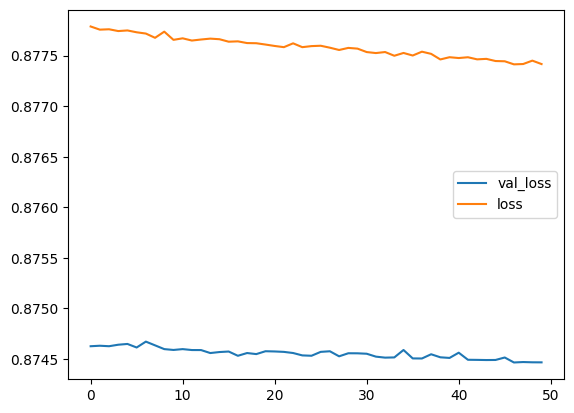

Best validation loss(mse): 0.8744654655456543


In [76]:
optimizer = tf.keras.optimizers.Adam(0.001)
tf_model.compile(optimizer=optimizer, loss='mean_squared_error')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_weights.weights.h5",
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Save only the best weights
    save_weights_only=True  # Save only the weights, not the entire model
)

history = tf_model.fit(X, y_train, epochs=50, batch_size=256, validation_data=(X_val_trans, y_val), callbacks=[checkpoint_callback])
val_loss = np.array(history.history['val_loss'])
loss = np.array(history.history['loss'])
plt.plot(val_loss, label='val_loss')
plt.plot(loss, label='loss')
plt.legend()
plt.show()
print("Best validation loss(mse):", val_loss.min())

In [77]:
tf_model.load_weights("best_weights.weights.h5")

y_val_pred = tf_model.predict(X_val_trans)
# round
y_val_pred = np.round(y_val_pred)

# mse
MSE = np.mean((y_val_pred - y_val)**2)
print("Validation MSE:", MSE)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
Validation MSE: 0.9496999142612175


In [83]:
# Get output for final test data
X_final_test = np.array(test.drop('ID', axis=1))
X_final_test_poly = transform_data(X_final_test)

y_final_test = tf_model.predict(X_final_test_poly)
y_final_test = np.round(y_final_test)

output = pd.DataFrame({'ID': test['ID'], 'score': y_final_test.flatten()})

output['score'] = output['score'].clip(0, 5)

# count score < 0
below0 = output[output['score'] < 0].shape[0]

# count score > 5
above5 = output[output['score'] > 5].shape[0]

print(output.shape[0], below0, above5)

output.to_csv('output9.csv', index=False)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
14996 0 0


In [84]:
# compare outut 8 and 9

output8 = pd.read_csv('output8.csv')
output9 = pd.read_csv('output9.csv')

diff = output8['score'] - output9['score']

print("No of differences:", diff[diff != 0].shape[0])

No of differences: 1875
